# Spatial Heterogeneity - Spatial Regimes

### Luc Anselin

### 02/10/2025

## Preliminaries

In this notebook, we consider discrete spatial heterogeneity in the form of spatial regimes, where the regimes have been specified *exogenously*. All the same specifications as before can be implemented in a regimes context, but we will focus only on the main ones: a standard regression (OLS), the spatial lag model with Spatial Durbin option, the spatial error model and an SLX model.

Implementation of the regimes estimation is by means of an additional `regimes` argument to specify the regimes variable, as well as some other specialized options, discussed below. In all other respects, the regressions operates in the same way as their non-regime counterparts in
`spreg.OLS`, `spreg.TSLS`, `GM_Lag`, `GMM_Error`, `ML_Lag`, and `ML_Error`.

Note that this requires `spreg` version 1.8.2. or later. Use `pip install -U spreg` to get the latest version.

### Modules Needed


In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from libpysal.io import open
from libpysal.examples import get_path
from spreg import OLS, GM_Lag, ML_Lag, GMM_Error, ML_Error

### Functions Used

- from geopandas:
  - read_file
  - plot
  
- from libpysal:
  - libpysal.examples.get_path
  - libpysal.io.open

- from spreg:
  - OLS
  - GM_Lag
  - GMM_Error
  - ML_Lag
  - ML_Error

### Data, Weights and Variables

As in the previous notebooks, all data sets, weights files and variables are specified at the top, so that they can be easily changed to other examples.

Data sets and weights are from the **chicagoSDOH** sample data set:

- **Chi-SDOH.shp,shx,dbf,prj**: socio-economic indicators of health for 2014 in 791 Chicago tracts
- **Chi-SDOH_q.gal**: queen contiguity spatial weights created with *GeoDa*

The weights are used in row-standardized form.

The initial model specification has **YPLL_rate** (an index measuring premature mortality, i.e., higher values are worse health outcomes) as the dependent variable, and **HIS_ct** (economic hardship index), **Blk14P** (percent Black population), and **Hisp14P** 
(percent Hispanic population) as the explanatory variables. These are specified in the **y_name** etc. variables. The *regime variable* is **regionno**, reflecting the *official* grouping of census tracts into *regions*. There are four such regions, ranging in size from 28 for region 1 to 334 for region 3. A concern with regimes is to make sure that there are sufficient observations in each regime to obtain stable coefficient estimates. 

The various initializations are carried out in two steps:

- first, all file names and variable names are defined
- second, the files are read and variable vectors/matrices constructed

The first step allows for customization to other examples, the second step is agnostic to the actual files and variables that were specified. To keep the code simple, there are no error checks for missing files or mismatches in the variable names.

#### Specify file and variable names

In [2]:
infileshp = get_path("Chi-SDOH.shp")            # input shape file with data
infileq = get_path("Chi-SDOH_q.gal")            # queen contiguity weights from GeoDa
y_name = 'YPLL_rate'
x_names = ['Blk14P','Hisp14P','HIS_ct']
rvar = 'regionno'
ds_name = 'Chi-SDOH'
w_name = 'Chi-SDOH_q'

#### Read files and extract variables

In [3]:
dfs = gpd.read_file(infileshp)
wq =  open(infileq).read()    # queen contiguity weights
wq.transform = 'r'    # row-transform the weights
y = dfs[y_name]
x = dfs[x_names]
regimes = dfs[rvar]

### Mapping the regimes

We obtain a quick visualization of the spatial layout of the regimes, using the `plot` method for a spatial data frame. For the unique values
map depicting the variable `regionno`, we use `categorical=True` as the classification.

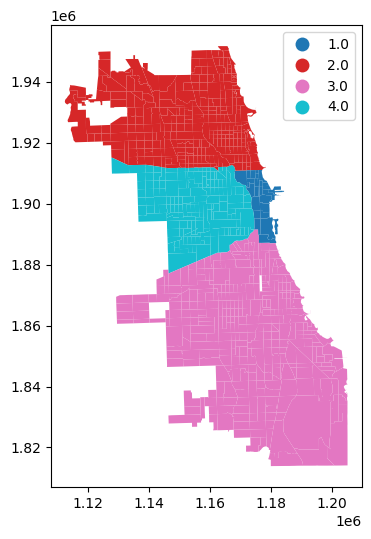

In [4]:
dfs.plot('regionno',categorical=True,figsize=(6,6),legend=True)
plt.show()

## Standard Models

### OLS

We start with a classic OLS estimation, carried out by means of the `OLS` function. All the arguments are the same as for a standard OLS regression, except for the addition of the `regimes` argument. In addition, we add a weights matrix and set `spat_diag = True` for spatial diagnostics. We get a listing of the results with the customary `summary` method.

The default treatment of the error term is to have a separate variance for each regime, i.e., it is modeled as groupwise heteroskedasticity. This is typically the most reasonable assumption in practice. It ensures that the regression coefficients and standard errors are identical to the result obtained when running the estimation separately on a subset of the observations corresponding to a given regime (easy to check as an exercise).

Note that the diagnostics for spatial effects are implemented under the assumption of a constant variance.

For a constant error variance across all regimes, the option is `regime_err_sep = False`. We will not consider this here. Since the
default is `regime_err_sep = True`, we do not need to specify it in the list of arguments, but it is included here for the sake of clarity.

In [5]:
reg1 = OLS(y, x, regimes=regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,
                        name_w=w_name,name_ds=ds_name)
print(reg1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 1
---------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  : 1_YPLL_rate                Number of Observations:          28
Mean dependent var  :   2898.1380                Number of Variables   :           4
S.D. dependent var  :   1464.6626                Degrees of Freedom    :          24
R-squared           :      0.5841
Adjusted R-squared  :      0.5321
Sum squared residual: 2.40889e+07                F-statistic           :     11.2359
Sigma-square        : 1003705.135                Prob(F-statistic)     :   8.466e-05
S.E. of regression  :    1001.851                Log likelihood        :    -231.041
Sigma-square ML     :  860318.687                Akaike info criterion :     470.082
S.E of regression ML:    927.5337                Schwarz criterion     :     475.411

----------------

The results listing contains a lot of information. For each regime, the coefficient estimates and measures of fit are listed as if they were a separate regression. The order is the order of the regime categories, i.e., the Central, North, South and West regions. This is easy to verify by checking the number of observations listed for each regime. The measures of fit are computed for the subset of observations corresponding to the regime in question. For example, for the smallest subset, the Central region with 28 observations, the adjusted R2 is 0.532. This measure varies considerably across regimes, e.g., with values of 0.304 in North (273 observations), 0.474 for South (334 observations), and 0.709 for West (156 observations). This compares to the overall fit in the homogeneous model of 0.632. It is important to keep in mind that the default is groupwise heteroskedasticity, i.e., a separate error variance in each regime. The same result would be obtained had the regression been run for just the subset of observations belonging to the regime.

The coefficient estimates and their significance vary considerably across regimes, highlighting the underlying spatial heterogeneity. The coefficient of Blk14P is highly significant and positive in the North, South and West, but not at all in the Central region. The coefficient of Hisp14P changes signs, from being negative and marginally significant (at respectively p < 0.04 and p < 0.02) in North and South, to being positive and highly significant in Central, and not significant in the West. Finally, economic hardship is always positive, but only strongly significant in North and South, marginally in Central (p < 0.03) and insignificant in the West (p < 0.07).

Each set of regime results also includes the customary non-spatial regression diagnostics for multicollinearity, non-normality and heteroskedasticity. However, diagnostics for spatial effects are only included for the full set of residuals (assuming a constant variance in the computations). The latter is because the preferred implementation of the spatial models is with a single spatial autoregressive coefficient. If a separate spatial coefficient is desired by regime, the recommended approach is to create actual subsets of the data and run separate regressions.

The overall diagnostics are given at the bottom of the listing. First the overall sum of squared residuals (SSR) is given, together with the number of regimes. This allows for a quick comparison with the results for other regime solutions, such as the endogenous regimes considered in the next notebook. Next is the Chow test for spatial heterogeneity. It indicates strong rejection of the null of homogeneity for the Hispanic coefficient, but not for economic hardship and weak evidence for the Blk14P coefficient. The overall test rejects the null at p < 0.02.

In addition, there is a global test for spatial effects, i.e., using the full set of residuals and spatial weights for all the observations. As in the standard OLS case, this includes both SARERR tests and the Spatial Durbin tests. There is some weak evidence for an overall spatial lag alternative, but this is not supported by the robust test. On the other hand, there is strong evidence for an SLX specification.

The object created by the regimes regression is quite complex, and contains several attributes, as illustrated by the `dir` command:

In [6]:
print(dir(reg1))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__summary', '__weakref__', '_cache', '_get_spat_diag_props', '_ols_regimes_multi', '_var_type', 'betas', 'chow', 'cols2regi', 'constant_regi', 'hac_var', 'k', 'kf', 'kr', 'kryd', 'lm_error', 'lm_lag', 'lm_sarma', 'lm_slxerr', 'lm_spdurbin', 'lm_wx', 'mean_y', 'multi', 'n', 'name_ds', 'name_gwk', 'name_regimes', 'name_w', 'name_x', 'name_x_r', 'name_y', 'nr', 'output', 'output_chow', 'predy', 'regime_err_sep', 'regimes', 'regimes_set', 'rlm_durlag', 'rlm_error', 'rlm_lag', 'rlm_wx', 'sig2n', 'sig2n_k', 'slx_lags', 'std_y', 'summary', 'u', 'utu', 'vm', 'x', 'xtx', 'xtxi', 'y']


The individual attributes can be extracted in the usual fashion. An attribute specific to regimes regression is `multi`, a dictionary that contains the regression attributes for each regime separately.

In [7]:
reg1.multi

{1: <spreg.ols.BaseOLS at 0x1355bb5f0>,
 2: <spreg.ols.BaseOLS at 0x135af4440>,
 3: <spreg.ols.BaseOLS at 0x135bbfaa0>,
 4: <spreg.ols.BaseOLS at 0x135be27b0>}

Note how reg1.multi is a dictionary, with the regime labels as keys. Hence, to extract the regression information for the first regime, we use the notation multi[1] and not multi[0], since 1 is the key for the first regime. 

In [9]:
print(dir(reg1.multi[1]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__summary', '__weakref__', '_cache', 'aic', 'ar2', 'betas', 'breusch_pagan', 'f_stat', 'jarque_bera', 'k', 'koenker_bassett', 'logll', 'mean_y', 'mulColli', 'n', 'name_ds', 'name_regimes', 'name_w', 'name_x', 'name_y', 'other_mid', 'other_top', 'predy', 'r2', 'robust', 'schwarz', 'sig2', 'sig2ML', 'sig2n', 'sig2n_k', 'std_err', 'std_y', 't_stat', 'title', 'u', 'utu', 'vm', 'w', 'x', 'xtx', 'xtxi', 'y']


### SLX

The regimes implementation for the SLX model is simply a special case of the OLS estimation, with the inclusion of `slx_lags=1`. The interpretation is the same as before.

In [10]:
slx1 = OLS(y, x, regimes=regimes, w=wq, spat_diag=True,
                        slx_lags=1,
                        regime_err_sep=True,
                        name_w=w_name,name_ds=ds_name)
print(slx1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION WITH SLX - REGIME 1
------------------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  : 1_YPLL_rate                Number of Observations:          28
Mean dependent var  :   2898.1380                Number of Variables   :           7
S.D. dependent var  :   1464.6626                Degrees of Freedom    :          21
R-squared           :      0.6499
Adjusted R-squared  :      0.5498
Sum squared residual: 2.02807e+07                F-statistic           :      6.4960
Sigma-square        :  965746.031                Prob(F-statistic)     :   0.0005461
S.E. of regression  :     982.724                Log likelihood        :    -228.632
Sigma-square ML     :  724309.523                Akaike info criterion :     471.264
S.E of regression ML:    851.0638                Schwarz criterion     :     480.589

The inclusion of the additional regressors is not very useful. Only W_HIS_ct is significant in the North and South regions, but none of the other spatially lagged explanatory variables are. The Global Chow tests rejects the null very strongly, at p < 0.01, supported by strong rejection for Hisp14P (p < 0.003) and Blk14P (p < 0.02), but not HIS_ct (p < 0.09). There is no evidence of overall spatial dependence. 

## Regime Regression Options

The regimes regression has several other options that we do not illustrate here. In addition to the `regime_err_sep = False` already referred to, it is also possible to get heteroskedastic-robust standard errors, with `robust="white"`, or HAC standard errors, with `robust="hac"` as illustrated in previous notebooks. In addition, there is an option to implement multiprocessing with the `cores` option (this may not work on all platforms).

A more unique option is the possibility to combine fixed coefficients with varying coefficients in so-called hybrid specifications.

The combination of fixed and varying coefficients is implemented through the arguments `constant_regi` and `cols2regi`. The first manages the constant term, or intercept, the second deals with the slope coefficients.

The default setting for `constant_regi` is `many`, which allows the intercept to vary by regime. The default for `cols2regi` is `all`, which has all the slope coefficients varying by regime.

By changing the default settings, several combinations are possible, such as:

- global constant, varying slope coefficients

- global or varying constant, some slope coefficients varying, some not

- varying constant, slope coefficient fixed (i.e., spatial fixed effects)


### Global Constant

The global constant is obtained by setting `constant_regi = 'one'`. The other coefficients are left to vary by regime.

In [11]:
reg2 = OLS(y, x, regimes=regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,
                        constant_regi='one',
                        name_w=w_name,name_ds=ds_name)
print(reg2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES (Group-wise heteroskedasticity)
-----------------------------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          13
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         778
R-squared           :      0.6377
Adjusted R-squared  :      0.6321

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
            1_Blk14P        24.32435        25.69841         0.94653         0.34417
           1_Hisp14P       124.58402        57.48807         

The listing of the results takes on a different format from the standard regimes output, in that all coefficients are listed together. At the bottom is the global (fixed) intercept coefficient. The measures of fit are global as well. In this example, the overall adjusted R2 is 0.632, the same as for the original global model.

The coefficient signs remain the same, but the significance changes slightly, with somewhat stronger 
results for economic hardship.

The (global) diagnostics for spatial effects point to an SLX or (weakly) Spatial Durbin alternative. The Chow test shows only very weak evidence for overall coefficient heterogeneity, and fails to reject the null for Blk14P and HIS_ct.

### Both Fixed and Varying Slope Coefficients

In light of the previous findings, we now only have the coefficient of Hisp14P vary by regime. This is specified through the `cols2regi` argument. It is a list of booleans (True, False) that indicates for each variable whether its coefficient is varying (True) or fixed (False). The order is the order in which the variables are specified in the x argument. The constant term is not included, since it is specified through `constant_regi`.
For example, with only Hisp14P as a varying coefficient, we would have the elements of the list as `False, True, False`. To keep the function call generic, we specify these settings in a separate list, `colsvari` and then set `cols2regi = colsvari` in the regime regression call.

In [12]:
colsvari = [False, True, False]

In [13]:
reg3 = OLS(y, x, regimes=regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,
                        constant_regi='one',cols2regi=colsvari,
                        name_w=w_name,name_ds=ds_name)
print(reg3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES (Group-wise heteroskedasticity)
-----------------------------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :           7
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         784
R-squared           :      0.6344
Adjusted R-squared  :      0.6316

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
           1_Hisp14P        46.80366        37.00533         1.26478         0.20633
           2_Hisp14P       -10.29306         4.17538        -

Even though the coefficient for Hisp14P varies considerably across regimes, because of the associated standard errors, the Chow test is not able to reject the null hypothesis.
Also, because the test is only applied on a single coefficient, the results for the test on Hisp14P and the Global test are identical.

The coefficient estimates for Blk14P and HIS_ct are close to their values in the homogeneous regression (respectively 42.09 and 72.73). There is now strong evidence pointing to a spatial lag alternative.

As before, the standard errors can be based on robust options, like `white` and `hac`. An additional option is to include a second iteration to obtain so-called *optimal* GMM standard errors, specified with the option `robust='ogmm'`.

In our example, this does not make much difference, except for a slightly better overall Chow test, but still not very convincing.

In [14]:
reg4 = OLS(y, x, regimes=regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,robust='ogmm',
                        constant_regi='one',cols2regi=colsvari,
                        name_w=w_name,name_ds=ds_name)
print(reg4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :           7
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         784
R-squared           :      0.6344
Adjusted R-squared  :      0.6316
Sum squared residual: 2.88682e+09                F-statistic           :    226.6980
Sigma-square        : 3682165.742                Prob(F-statistic)     :  1.628e-167
S.E. of regression  :    1918.897                Log likelihood        :   -7098.434
Sigma-square ML     : 3649580.204                Akaike info criterion :   14210.868
S.E of regression ML:   1910.3874                Schwarz criterion     :   14243.581

Optimal GMM used to estimate the coeffic

### Spatial Fixed Effects

An alternative specification only lets the constant vary by regimes, as so-called *spatial fixed effects*. This is achieved by setting `constant_regi = 'many'` with the list `colsvari = [False, False, False].

In [15]:
colsvari = [False, False, False]

In [16]:
reg5 = OLS(y, x, regimes=regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,
                        constant_regi='many',cols2regi=colsvari,
                        name_w=w_name,name_ds=ds_name)
print(reg5.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES (Group-wise heteroskedasticity)
-----------------------------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :           7
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         784
R-squared           :      0.6340
Adjusted R-squared  :      0.6312

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT       930.11721       284.65010         3.26758         0.00113
          2_CONSTANT       978.18258       193.30109         

The spatial fixed effects coefficients are all highly significant, but not sufficiently different for the Chow test to reject the null.

## Spatial Lag Model

The regimes specification for a spatial lag model can be estimated either by means of IV/GMM with `spreg.GM_Lag` or by means of maximum likelihood with `spreg.ML_Lag`.

The arguments are the same as for the standard spatial lag model, with the addition of the `regimes` setting, and the regime-specific options discussed above. In the case of GMM estimation, additional endogenous variables may be included as well, with matching instruments. We do not consider this case here.

The default (highly recommended) is to have a *global* spatial autoregressive coefficient. If a separate autoregression is desired for each regime, the option `regime_lag_sep` is used. The default is `False`. It should be noted that the spatial weights used when a separate spatial model is specified of each regime are the *truncated* weights. This removes the connectivity structure between observations that belong to different regimes. This is typically not desired in practice, hence the default setting, although there may be situations where it is appropriate (e.g., for block-diagonal weights). The results are the same as if a separate weights matrix was constructed for each regime and the spatial model estimated for that subset of observations. 

### IV/GMM Estimation

GMM estimation is implemented through `GM_Lag` with the appropriate regime-specific arguments. The arguments are the same as for the standard regression case, with the addition of the spatial weights `w` (and their name) and an option for the number of spatial lags for the instruments, here `w_lags=2`.

The same hybrid specifications are allowed as for the standard models by means of the `constant_regi` and `cols2regi` arguments. This is no longer considered further.

In the spatial models, there are two important options pertaining to the error variance and the spatial coefficient. Whereas in OLS estimation, the default is `regime_err_sep=True`, for groupwise heteroskedasticity, this is not the case for the spatial models. The default is to have a single spatial coefficients, i.e., `regime_lag_sep=False`, with `regime_err_sep=False`, but with `robust='white'` for robust standard errors.

For clarity, these arguments are specified explicitly, even though they are the defaults.

In [17]:
lag1 = GM_Lag(y, x, regimes=regimes, w=wq, w_lags=2,
                        regime_lag_sep=False,regime_err_sep=False,robust='white',
                        name_w=w_name,name_ds=ds_name)
print(lag1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES - REGIMES
------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          17
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         774
Pseudo R-squared    :      0.6416
Spatial Pseudo R-squared:  0.6376

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT     -1153.47854      1091.82983        -1.05646         0.29076
            1_Blk14P       -19.37723        25.56430        -0.75798         0.44846


The coefficient listing has the global estimate for the spatial autoregressive coefficient at the bottom. 
The estimate of 0.251 is not significant. The regimes coefficient estimates are a little different from before: Blk14P is significant and positive in all regions except the first (Central); Hisp14P is only significant (and positive!) in the Central region; while HIS_ct is significant and positive everywhere except in the West.

The (spatial) Chow test again shows only weak evidence of heterogeneity, failing to reject the null for HIS_ct, and only weakly rejecting for the Global test (p < 0.05), Blk (p < 0.04) and Hisp14P (p < 0.03).

As in the non-regime spatial lag model, an estimate is provided of the direct, indirect and total impacts. The default is the `'simple'` option, listed here.

#### Optimal GMM Estimation

In addition to the `"white"` and `"hac"` options, it is also possible to apply an iterative estimation process in the GM methods. This yields a so-called *optimal* GMM result. In essence, this consists of a second step in which in a White-like fashion, the squared residuals from the first step are used to to create weighted instruments, which improve the precision of the estimates.

This option is implemented by means of `robust="ogmm"`:

In [18]:
lag2 = GM_Lag(y, x, regimes=regimes, w=wq, w_lags=2,
                        regime_lag_sep= False, regime_err_sep = False, robust='ogmm',
                        name_w=w_name,name_ds=ds_name)
print(lag2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES - REGIMES
------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          17
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         774
Pseudo R-squared    :      0.6346
Spatial Pseudo R-squared:  0.6324

Optimal GMM used to estimate the coefficients and the variance-covariance matrix
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT     -1467.54827       763.91307        -1.92109         0.05472
            1_Blk14P      

The result indeed yields greater precision for the coefficient estimates. The main impact is on the estimate for the spatial autoregressive parameter, which now becomes 0.417 and is highly significant (p < 0.00001). This does not affect the overall pattern of significance much for the other coefficients, but it has an effect on the Chow tests. The global case is now rejected at p < 0.003, and the null is strongly rejected for Blk14P and Hisp14P. For HIS_ct, there is no evidence of coefficient heterogeneity. In constrast to the previous results, there is now some indication of remaining residual spatial autocorrelation.

#### Separate Spatial Lag Models by Regime

It is possible to set `regime_lag_sep=True`, but then `regime_err_sep` also needs to be set to `True`, essentially resulting in a separate spatial regression by regime, with truncated spatial weights. If this is not the case, it will be done by the program and a warning will be included in the output listing. The default remains White standard errors, which can be changed by setting `robust=None` for simple groupwise heteroskedasticity.

In [19]:
lag3 = GM_Lag(y, x, regimes=regimes, w=wq, w_lags=2,
                        regime_lag_sep=True,robust=None,
                        name_w=w_name,name_ds=ds_name)
print(lag3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES ESTIMATION - REGIME 1
------------------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  : 1_YPLL_rate                Number of Observations:          28
Mean dependent var  :   2898.1380                Number of Variables   :           5
S.D. dependent var  :   1464.6626                Degrees of Freedom    :          23
Pseudo R-squared    :      0.5863
Spatial Pseudo R-squared:  0.5892

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT      -578.98110       998.84029        -0.57965         0.56215
            1_Blk14P        -5.19232        26.12557        -0.19874         0.8424

The separate spatial regressions provide strong evidence to reject the null of homogeneity for all variables except Blk14P. The overall test is also highly significant. The separate spatial autoregressive coefficient is only significant in regime 3. Note that this is based on truncated weights and therefore assumes that each regime is a spatial island, without any interaction with the other regimes. In practice, this is typically only appropriate in the case of block weights, where the regimes are in fact unconnected components in a graph-theoretic sense.

### ML Estimation

Estimation of spatial lag regimes by means of maximum likelihood is implemented with `spreg.ML_Lag` with the appropriate regime-specific arguments. The arguments are the same as for the standard regimes case, again with the addition of the spatial weights (and their name) and the specification of the optimization method, here `ord`.

In contrast to the case for IV/GMM estimation, there is no `regime_err_sep` option, nor `robust` standard errors for maximum likelihood. The default for `regime_lag_sep` is again `False`, but it is possible to run separate spatial lag regressions in each regime, with the same caveat as before.

As before, direct, indirect and total impact estimates are computed and listed at the bottom of the results.

In [20]:
lag4 = ML_Lag(y, x, regimes=regimes, w=wq, method='ord',
                        regime_lag_sep=False,
                        name_w=w_name,name_ds=ds_name)
print(lag4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = ord)
--------------------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          17
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         774
Pseudo R-squared    :      0.6418
Spatial Pseudo R-squared:  0.6387
Log likelihood      :  -7091.3091
Sigma-square ML     :3575552.2703                Akaike info criterion :   14216.618
S.E of regression   :   1890.9131                Schwarz criterion     :   14296.064

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------

Interestingly, the global spatial autoregressive coefficient is very similar in value to the results for **lag1** above and is strongly significant. But, in contrast, there is no evidence to support coefficient heterogeneity. 

When there are large differences between the GMM and ML estimates, the results should be interpreted with caution. On the one hand, maybe the sample size is not large enough for the asymptotic properties of GMM to kick in. On the other hand, the strong assumption of normality may not be reasonable for the ML case.

## Spatial Durbin Model

The regimes specification for a Spatial Durbin model can be obtained as a special case of the spatial lag model with `slx_lags=1` (or higher) included as one of the arguments to either `GM_Lag` or `ML_Lag`. Since the inclusion of the WX terms in the SLX estimation above did not suggest any spatial effects, we do not pursue this further here.

## Spatial Error Model

The regimes specification for spatial error models can be estimated by means of either GMM or maximum likelihood. The corresponding commands are `GMM_Error` and `ML_Error` with the appropriate regime-specific arguments.

The default setting is to again have a single spatial coefficients with `regime_err_sep = False`. The `robust` options are irrelevant since heteroskedasticity can be accounted for in GMM through `estimator='het'` and is not supported in ML estimation.

### GMM Estimation

The regime-specific arguments to `GMM_Error` are the same as above (allowing for hybrid models, etc.) and the other arguments are the same as for the standard `GMM_Error`. The default `estimator='het'` for heteroskedastic-robust standard errors. We only show results for the default case. The other options can be examined in the usual way.

In [21]:
err1 = GMM_Error(y, x, regimes=regimes, w=wq, 
                        name_w=w_name,name_ds=ds_name)
print(err1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED MODEL (HET) - REGIMES
--------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          16
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         775
Pseudo R-squared    :      0.6378
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT      -236.49327       866.75592        -0.27285         0.78497
            1_Blk14P        -3.62300        24.59641

The global spatial autoregressive coefficient is significant with a p-value less than 0.003. The Global Chow test is not significant, and there is only weak indication of heterogeneity for the Hisp14P coefficient (p < 0.03).

The other coefficients show the usual pattern. Blk14P is strongly significant and positive in all but the Central region; Hisp14P is only significant in the Central region, but positive; and HIS_ct is significant and positive in all regions, except for the West (p < 0.08).

### ML Estimation

The arguments are the same as for `ML_Error` with the appropriate regimes argument. Here, we specify `method='LU'`.

In [23]:
err2 = ML_Error(y, x, regimes=regimes, w=wq, method="LU",
                        name_w=w_name,name_ds=ds_name)
print(err2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR - REGIMES (METHOD = LU)
-----------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          16
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         775
Pseudo R-squared    :      0.6378
Log likelihood      :  -7092.2455
Sigma-square ML     :3582442.2623                Akaike info criterion :   14216.491
S.E of regression   :   1892.7341                Schwarz criterion     :   14291.264

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT    

The spatial autoregressive coefficient is 0.125, only weakly significant at p < 0.04. None of the Chow tests reject the null hypothesis of homogeneity.

## Other Error Models

As in the standard case, the SLX-Error model, the SARSAR model and the GNS model can be obtained by passing the proper combination of `slx_lags=1` and `add_wy=True` arguments to the `GMM_Error` command. We do not further consider this.

## Practice

The functions considered here have many options. Assess the effect of these
options on the results and interpretation. For example, allow some regressors to vary while
keeping others fixed, check the impact of heteroskedasticity on the standard errors,
and/or vary the spatial weights. Which of the various specifications seems to make the
most sense in this example?